### Use CIGALE to fit the COSMOS2020 SEDs for HSC-SSP AGNs

In [24]:
%matplotlib inline
import sys, os, glob

from astropy.io import fits, ascii

import numpy as np
import matplotlib.pyplot as plt
from astropy import units as u
import astropy.constants as const
from astropy.coordinates import SkyCoord, concatenate
from astropy import table

In [25]:
import scienceplots

plt.style.use([ 'bright', 'science', 'no-latex', 'notebook'])

### Read the updated HSC-SSP AGN table:

https://ui.adsabs.harvard.edu/abs/2020ApJ...894...24K/abstract

In [26]:
# Read HSC-SSP AGNs
data_agn = ascii.read('hsc_agn_updated.txt')
cat_agn = SkyCoord(data_agn['RAdeg'], data_agn['DEdeg'], unit='deg')
data_agn
# TODO: Also read Chandra COSMOS legacy and re-do Mar's analysis

ID,RAdeg,DEdeg,i-mag,X-flag,g-flag,r-flag,i-flag,z-flag,n-corr,z,r_z,ID-COSMOS2015,bibcode
int64,float64,float64,float64,int64,int64,int64,int64,int64,int64,float64,int64,int64,str19
1,150.74386,2.20245,22.71,1,1,1,1,1,6,1.561,3,594392,-------------------
2,150.73557,2.19957,20.36,1,1,1,1,1,6,3.503096,1,592797,2020ApJ...894...24K
3,150.73353,2.15646,20.88,1,1,1,1,1,6,0.9769,1,565402,2020ApJ...894...24K
4,150.79702,2.13888,21.01,1,1,1,1,1,6,0.5727,1,552225,2020ApJ...894...24K
5,150.78259,2.19306,20.63,1,1,1,1,1,6,0.5847,1,589540,2020ApJ...894...24K
6,150.72019,2.24803,21.13,1,1,1,1,1,6,0.6633,1,625595,2020ApJ...894...24K
7,150.78838,2.34399,19.82,1,1,1,1,1,6,1.964449,1,689768,2020ApJ...894...24K
8,150.71511,2.48483,19.2,1,1,1,1,1,6,1.995,1,782508,2020ApJ...894...24K
9,150.71391,1.97214,22.87,1,1,1,1,1,5,1.474,3,445280,-------------------


Match to COSMOS2020 to get photometry 

In [27]:
# Follows
# https://github.com/cosmic-dawn/cosmos2020-readcat/blob/main/COSMOS2020_readcat.ipynb

# Specify the version of the catalog and the folder with the input/output files
catversion = 'Farmer'  # this string can be either 'Classic' or 'Farmer'

# Point to the directory
dir_in = './'  
dir_out = './'  # the directory where the output of this notebook will be stored

# Which type of photometric estimates to use? (suffix of the column name)
# This choice must be consistent with `catversion`,
# choices for Classic are: '_FLUX_APER2', '_FLUX_APER3', '_MAG_APER2,', '_MAG_APER3'
# choices for Farmer are '_FLUX' or '_MAG' 
flx = '_FLUX'  
flxerr = '_FLUXERR'  # catalog column for flux/mag error, just add 'ERR'
outflx = 'uJy' # 'cgs' or 'uJy'

# Filter names, mean wavelength, and other info (see Table 1 in W+21)
filt_name = ['CHANDRA','GALEX_FUV','GALEX_NUV','CFHT_u','HSC_g', 'HSC_r', 'HSC_i', 'HSC_z', 'HSC_y', 'UVISTA_Y', 'UVISTA_J', 'UVISTA_H', 'UVISTA_Ks', 'SC_IB427', 'SC_IB464', 'SC_IA484', 'SC_IB505', 'SC_IA527', 'SC_IB574', 'SC_IA624', 'SC_IA679', 'SC_IB709', 'SC_IA738', 'SC_IA767', 'SC_IB827', 'SC_NB711', 'SC_NB816', 'UVISTA_NB118', 'SC_B', 'SC_gp', 'SC_V', 'SC_rp', 'SC_ip','SC_zp', 'SC_zpp', 'IRAC_CH1', 'IRAC_CH2', 'IRAC_CH3','IRAC_CH4']  
filt_lambda = [2.07e-4, 0.1526,0.2307,0.3709,0.3858,0.4847,0.6219,0.7699,0.8894,0.9761,1.0216,1.2525,1.6466,2.1557,0.4266,0.4635,0.4851,0.5064,0.5261,0.5766,0.6232,0.6780,0.7073,0.7361,0.7694,0.8243,0.7121,0.8150,1.1909,0.4488,0.4804,0.5487,0.6305,0.7693,0.8978,0.9063,3.5686,4.5067,5.7788,7.9958]
filt_fwhm = [3.1e-4,0.0224,0.07909,0.05181,0.05976,0.1383,0.1547,0.1471,0.0766,0.0786,0.0923,0.1718,0.2905,0.3074,0.02073,0.02182,0.02292,0.0231,0.02429,0.02729,0.03004,0.03363,0.03163,0.03235,0.03648,0.0343,0.0072,0.01198,0.01122,0.0892,0.1265,0.0954,0.1376,0.1497,0.0847,0.1335,0.7443,1.0119,1.4082,2.8796] 
# corresponding MW attenuation from Schelgel 
AlambdaDivEBV = [8.31,8.742,4.807,4.674,3.69,2.715,2.0,1.515,1.298,1.213,0.874,0.565,0.365,4.261,3.844,3.622,3.425,3.265,2.938,2.694,2.431,2.29,2.151,1.997,1.748,2.268,1.787,0.946,4.041,3.738,3.128,2.673,2.003,1.436,1.466,0.163,0.112,0.075,0.045]
# photometric offsets (not available for all filters, see Table 3 in W+21)
zpoff1 = [0.000,0.000,-0.352,-0.077,-0.023,0.073,0.101,0.038,0.036,0.086,0.054,0.017,-0.045,0.000,-0.104,-0.044,-0.021,-0.018,-0.045,-0.084,0.005,0.166,-0.023,-0.034,-0.032,-0.069,-0.010,-0.064,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-0.212,-0.219,0.000,0.000]  # Farmer+LePhare
zpoff2 = [0.000,0.000,-0.029,-0.006,0.053,0.128,0.127,0.094,0.084,0.100,0.049,0.025,-0.044,0.000,-0.013,-0.008,0.022,0.025,0.033,-0.032,0.031,0.208,-0.009,0.003,-0.015,-0.001,0.023,-0.021,-0.017,-0.075,0.000,0.123,0.035,0.051,0.000,0.095,-0.087,-0.111,0.000,0.000]  # Classic+LePhare
zpoff3 = [0.000,0.000,0.000,-0.196,-0.054,0.006,0.090,0.043,0.071,0.118,0.078,0.047,-0.034,0.000,-0.199,-0.129,-0.084,-0.073,-0.087,-0.124,0.004,0.154,-0.022,-0.030,-0.013,-0.057,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,-0.102,-0.044,0.000,0.000] # Farmer+EAZY
zpoff4 = [0.000,0.000,0.000,0.000,-0.021,0.055,0.124,0.121,0.121,0.145,0.085,0.057,-0.036,0.000,-0.133,-0.098,-0.046,-0.037,-0.038,-0.062,0.038,0.214,0.024,0.022,0.01,0.022,0.000,0.000,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.021,0.025,0.000,0.000] # Classic+EAZY
# create the dictionary
filt_dict = {filt_name[i]:(filt_lambda[i]*1e4,filt_fwhm[i]*1e4,AlambdaDivEBV[i],[zpoff1[i],zpoff2[i],zpoff3[i],zpoff4[i]]) for i in range(len(filt_name))}

In [28]:
# Read
data_cosmos2020 = table.Table.read(dir_in+'COSMOS2020_{}_R1_v2.2_p3.fits'.format(catversion.upper()),format='fits',hdu=1)

# Create a mask to restrict the analysis to a subset of filters (optional)
# 'CHANDRA'
filt_use = ['GALEX_FUV','GALEX_NUV','CFHT_u', 'HSC_g', 'HSC_r', 'HSC_i', 'HSC_z', 'HSC_y', 'UVISTA_Y', 'UVISTA_J', 'UVISTA_H', 'UVISTA_Ks', 'IRAC_CH1', 'IRAC_CH2', 'IRAC_CH3', 'IRAC_CH4']
filt_mask = [i in filt_use for i in filt_name]

whichflag = 'COMBINED'  # you can try HSC, SUPCAM, UVISTA, UDEEP, COMBINED
print('The parent sample includes {} sources'.format(len(data_cosmos2020)))
data_cosmos2020 = data_cosmos2020[data_cosmos2020['FLAG_{}'.format(whichflag)]==0]
print('Now restricted to {} sources by using FLAG_COMBINED'.format(len(data_cosmos2020)))

The parent sample includes 964506 sources
Now restricted to 746976 sources by using FLAG_COMBINED


In [29]:
data_cosmos2020

ID,ALPHA_J2000,DELTA_J2000,X_MODEL,Y_MODEL,ERRX_MODEL,ERRY_MODEL,ALPHA_DETECTION,DELTA_DETECTION,FARMER_ID,GROUP_ID,N_GROUP,MODEL_FLAG,SOLUTION_MODEL,FLAG_HSC,FLAG_SUPCAM,FLAG_UDEEP,FLAG_UVISTA,FLAG_COMBINED,EBV_MW,CFHT_u_FLUX,CFHT_u_FLUXERR,CFHT_u_MAG,CFHT_u_MAGERR,CFHT_u_CHISQ,CFHT_u_DRIFT,CFHT_u_VALID,CFHT_ustar_FLUX,CFHT_ustar_FLUXERR,CFHT_ustar_MAG,CFHT_ustar_MAGERR,CFHT_ustar_CHISQ,CFHT_ustar_DRIFT,CFHT_ustar_VALID,HSC_g_FLUX,HSC_g_FLUXERR,HSC_g_MAG,HSC_g_MAGERR,HSC_g_CHISQ,HSC_g_DRIFT,HSC_g_VALID,HSC_r_FLUX,HSC_r_FLUXERR,HSC_r_MAG,HSC_r_MAGERR,HSC_r_CHISQ,HSC_r_DRIFT,HSC_r_VALID,HSC_i_FLUX,HSC_i_FLUXERR,HSC_i_MAG,HSC_i_MAGERR,HSC_i_CHISQ,HSC_i_DRIFT,HSC_i_VALID,HSC_z_FLUX,HSC_z_FLUXERR,HSC_z_MAG,HSC_z_MAGERR,HSC_z_CHISQ,HSC_z_DRIFT,HSC_z_VALID,HSC_y_FLUX,HSC_y_FLUXERR,HSC_y_MAG,HSC_y_MAGERR,HSC_y_CHISQ,HSC_y_DRIFT,HSC_y_VALID,UVISTA_Y_FLUX,UVISTA_Y_FLUXERR,UVISTA_Y_MAG,UVISTA_Y_MAGERR,UVISTA_Y_CHISQ,UVISTA_Y_DRIFT,UVISTA_Y_VALID,UVISTA_J_FLUX,UVISTA_J_FLUXERR,UVISTA_J_MAG,UVISTA_J_MAGERR,UVISTA_J_CHISQ,UVISTA_J_DRIFT,UVISTA_J_VALID,UVISTA_H_FLUX,UVISTA_H_FLUXERR,UVISTA_H_MAG,UVISTA_H_MAGERR,UVISTA_H_CHISQ,UVISTA_H_DRIFT,UVISTA_H_VALID,UVISTA_Ks_FLUX,UVISTA_Ks_FLUXERR,UVISTA_Ks_MAG,UVISTA_Ks_MAGERR,UVISTA_Ks_CHISQ,UVISTA_Ks_DRIFT,UVISTA_Ks_VALID,UVISTA_NB118_FLUX,UVISTA_NB118_FLUXERR,UVISTA_NB118_MAG,UVISTA_NB118_MAGERR,UVISTA_NB118_CHISQ,UVISTA_NB118_DRIFT,UVISTA_NB118_VALID,SC_IB427_FLUX,SC_IB427_FLUXERR,SC_IB427_MAG,SC_IB427_MAGERR,SC_IB427_CHISQ,SC_IB427_DRIFT,SC_IB427_VALID,SC_IB464_FLUX,SC_IB464_FLUXERR,SC_IB464_MAG,SC_IB464_MAGERR,SC_IB464_CHISQ,SC_IB464_DRIFT,SC_IB464_VALID,SC_IA484_FLUX,SC_IA484_FLUXERR,SC_IA484_MAG,SC_IA484_MAGERR,SC_IA484_CHISQ,SC_IA484_DRIFT,SC_IA484_VALID,SC_IB505_FLUX,SC_IB505_FLUXERR,SC_IB505_MAG,SC_IB505_MAGERR,SC_IB505_CHISQ,SC_IB505_DRIFT,SC_IB505_VALID,SC_IA527_FLUX,SC_IA527_FLUXERR,SC_IA527_MAG,SC_IA527_MAGERR,SC_IA527_CHISQ,SC_IA527_DRIFT,SC_IA527_VALID,SC_IB574_FLUX,SC_IB574_FLUXERR,SC_IB574_MAG,SC_IB574_MAGERR,SC_IB574_CHISQ,SC_IB574_DRIFT,SC_IB574_VALID,SC_IA624_FLUX,SC_IA624_FLUXERR,SC_IA624_MAG,SC_IA624_MAGERR,SC_IA624_CHISQ,SC_IA624_DRIFT,SC_IA624_VALID,SC_IA679_FLUX,SC_IA679_FLUXERR,SC_IA679_MAG,SC_IA679_MAGERR,SC_IA679_CHISQ,SC_IA679_DRIFT,SC_IA679_VALID,SC_IB709_FLUX,SC_IB709_FLUXERR,SC_IB709_MAG,SC_IB709_MAGERR,SC_IB709_CHISQ,SC_IB709_DRIFT,SC_IB709_VALID,SC_IA738_FLUX,SC_IA738_FLUXERR,SC_IA738_MAG,SC_IA738_MAGERR,SC_IA738_CHISQ,SC_IA738_DRIFT,SC_IA738_VALID,SC_IA767_FLUX,SC_IA767_FLUXERR,SC_IA767_MAG,SC_IA767_MAGERR,SC_IA767_CHISQ,SC_IA767_DRIFT,SC_IA767_VALID,SC_IB827_FLUX,SC_IB827_FLUXERR,SC_IB827_MAG,SC_IB827_MAGERR,SC_IB827_CHISQ,SC_IB827_DRIFT,SC_IB827_VALID,SC_NB711_FLUX,SC_NB711_FLUXERR,SC_NB711_MAG,SC_NB711_MAGERR,SC_NB711_CHISQ,SC_NB711_DRIFT,SC_NB711_VALID,SC_NB816_FLUX,SC_NB816_FLUXERR,SC_NB816_MAG,SC_NB816_MAGERR,SC_NB816_CHISQ,SC_NB816_DRIFT,SC_NB816_VALID,IRAC_CH1_FLUX,IRAC_CH1_FLUXERR,IRAC_CH1_MAG,IRAC_CH1_MAGERR,IRAC_CH1_CHISQ,IRAC_CH1_DRIFT,IRAC_CH1_VALID,IRAC_CH2_FLUX,IRAC_CH2_FLUXERR,IRAC_CH2_MAG,IRAC_CH2_MAGERR,IRAC_CH2_CHISQ,IRAC_CH2_DRIFT,IRAC_CH2_VALID,IRAC_CH3_FLUX,IRAC_CH3_FLUXERR,IRAC_CH3_MAG,IRAC_CH3_MAGERR,IRAC_CH3_CHISQ,IRAC_CH3_DRIFT,IRAC_CH3_VALID,IRAC_CH4_FLUX,IRAC_CH4_FLUXERR,IRAC_CH4_MAG,IRAC_CH4_MAGERR,IRAC_CH4_CHISQ,IRAC_CH4_DRIFT,IRAC_CH4_VALID,ID_GALEX,GALEX_NUV_FLUX,GALEX_NUV_FLUXERR,GALEX_NUV_MAG,GALEX_NUV_MAGERR,GALEX_FUV_FLUX,GALEX_FUV_FLUXERR,GALEX_FUV_MAG,GALEX_FUV_MAGERR,ID_COSMOS2015,SPLASH_CH1_FLUX,SPLASH_CH1_FLUXERR,SPLASH_CH1_MAG,SPLASH_CH1_MAGERR,SPLASH_CH2_FLUX,SPLASH_CH2_FLUXERR,SPLASH_CH2_MAG,SPLASH_CH2_MAGERR,SPLASH_CH3_FLUX,SPLASH_CH3_FLUXERR,SPLASH_CH3_MAG,SPLASH_CH3_MAGERR,SPLASH_CH4_FLUX,SPLASH_CH4_FLUXERR,SPLASH_CH4_MAG,SPLASH_CH4_MAGERR,ID_ACS,ACS_F814W_MAG,ACS_F814W_MAGERR,ACS_F814W_FLUX,ACS_F814W_FLUXERR,ACS_A_WORLD,ACS_B_WORLD,ACS_THETA_WORLD,ACS_FWHM_WORLD,ACS_MU_MAX,ACS_MU_CLASS,ID_CHANDRA,ID_CLASSIC,lp_zBEST,lp_type,lp_zPDF,lp_zPDF_l68,lp_zPDF_u68,lp_zMinChi2,lp_chi2_best,lp_zp_2,lp_chi2_2,lp_NbFilt,lp_zq,lp

In [30]:
# Actually do the matching to COSMOS2020

cat_COSMOS2020 = SkyCoord(data_cosmos2020['ALPHA_J2000'], data_cosmos2020['DELTA_J2000'], unit='deg')

idx_agn2COSMOS20, idx_COSMOS20, d2d, d3d = cat_COSMOS2020.search_around_sky(cat_agn, 0.5*u.arcsec)
print(len(idx_COSMOS20), print(len(cat_agn)))

491
324 None


In [31]:
data_cosmos2020.columns

<TableColumns names=('ID','ALPHA_J2000','DELTA_J2000','X_MODEL','Y_MODEL','ERRX_MODEL','ERRY_MODEL','ALPHA_DETECTION','DELTA_DETECTION','FARMER_ID','GROUP_ID','N_GROUP','MODEL_FLAG','SOLUTION_MODEL','FLAG_HSC','FLAG_SUPCAM','FLAG_UDEEP','FLAG_UVISTA','FLAG_COMBINED','EBV_MW','CFHT_u_FLUX','CFHT_u_FLUXERR','CFHT_u_MAG','CFHT_u_MAGERR','CFHT_u_CHISQ','CFHT_u_DRIFT','CFHT_u_VALID','CFHT_ustar_FLUX','CFHT_ustar_FLUXERR','CFHT_ustar_MAG','CFHT_ustar_MAGERR','CFHT_ustar_CHISQ','CFHT_ustar_DRIFT','CFHT_ustar_VALID','HSC_g_FLUX','HSC_g_FLUXERR','HSC_g_MAG','HSC_g_MAGERR','HSC_g_CHISQ','HSC_g_DRIFT','HSC_g_VALID','HSC_r_FLUX','HSC_r_FLUXERR','HSC_r_MAG','HSC_r_MAGERR','HSC_r_CHISQ','HSC_r_DRIFT','HSC_r_VALID','HSC_i_FLUX','HSC_i_FLUXERR','HSC_i_MAG','HSC_i_MAGERR','HSC_i_CHISQ','HSC_i_DRIFT','HSC_i_VALID','HSC_z_FLUX','HSC_z_FLUXERR','HSC_z_MAG','HSC_z_MAGERR','HSC_z_CHISQ','HSC_z_DRIFT','HSC_z_VALID','HSC_y_FLUX','HSC_y_FLUXERR','HSC_y_MAG','HSC_y_MAGERR','HSC_y_CHISQ','HSC_y_DRIFT','HSC_y_VAL

In [32]:
# Fix up the X-ray fluxes:
# This doesn't really do anything except reformat the columns
data_cosmos2020['ID_CHANDRA'] = data_cosmos2020['ID_CHANDRA'].astype(str)

"""
data_cosmos2020['CHANDRA_FLUX'] = data_cosmos2020['col25']
data_cosmos2020['CHANDRA_FLUXERR'] = data_cosmos2020['col26']
data_cosmos2020['CHANDRA_FLUXERR'].data.data[data_cosmos2020['CHANDRA_FLUXERR']=='---'] = -999
data_cosmos2020['CHANDRA_FLUXERR'] = np.ma.masked_array(data_cosmos2020['CHANDRA_FLUXERR'].data.data.astype(float))
# Units at 4 KeV
data_cosmos2020['CHANDRA_FLUX'] = np.ma.masked_array(data_cosmos2020['CHANDRA_FLUX'].data.data*(1*u.mW/(u.m**2*9.671e17*u.Hz)).to(u.uJy).value)
data_cosmos2020['CHANDRA_FLUXERR'] = np.ma.masked_array(data_cosmos2020['CHANDRA_FLUXERR'].data.data*(1*u.mW/(u.m**2*9.671e17*u.Hz)).to(u.uJy).value)
"""

"\ndata_cosmos2020['CHANDRA_FLUX'] = data_cosmos2020['col25']\ndata_cosmos2020['CHANDRA_FLUXERR'] = data_cosmos2020['col26']\ndata_cosmos2020['CHANDRA_FLUXERR'].data.data[data_cosmos2020['CHANDRA_FLUXERR']=='---'] = -999\ndata_cosmos2020['CHANDRA_FLUXERR'] = np.ma.masked_array(data_cosmos2020['CHANDRA_FLUXERR'].data.data.astype(float))\n# Units at 4 KeV\ndata_cosmos2020['CHANDRA_FLUX'] = np.ma.masked_array(data_cosmos2020['CHANDRA_FLUX'].data.data*(1*u.mW/(u.m**2*9.671e17*u.Hz)).to(u.uJy).value)\ndata_cosmos2020['CHANDRA_FLUXERR'] = np.ma.masked_array(data_cosmos2020['CHANDRA_FLUXERR'].data.data*(1*u.mW/(u.m**2*9.671e17*u.Hz)).to(u.uJy).value)\n"

### Photo-z comparison

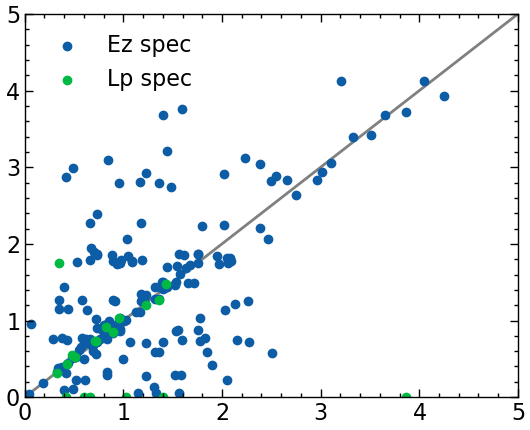

In [56]:
z_hsc = data_agn['z'][idx_agn2COSMOS20]
z_ez = data_cosmos2020['ez_z_phot'][idx_COSMOS20]
z_lp = data_cosmos2020['lp_zBEST'][idx_COSMOS20]

mask_spec = data_agn['r_z'][idx_agn2COSMOS20] < 3

fig, ax = plt.subplots(1,1, figsize=(5.5, 4.5))
ax.scatter(z_hsc[mask_spec], z_ez[mask_spec], label='Ez spec')
ax.scatter(z_hsc[mask_spec], z_lp[mask_spec], label='Lp spec')

#ax.scatter(z_ez[~mask_spec], z_hsc[~mask_spec], label='Ez ph')
#ax.scatter(z_lp[~mask_spec], z_hsc[~mask_spec], label='Lp ph')

ax.legend()
ax.plot([-1, 5], [-1, 5], color='gray', zorder=-1)

ax.set_xlim(0, 5)
ax.set_ylim(0, 5)

fig.tight_layout()


### Generate the CIGALE input files

In [62]:
print(filt_use)

['GALEX_FUV', 'GALEX_NUV', 'CFHT_u', 'HSC_g', 'HSC_r', 'HSC_i', 'HSC_z', 'HSC_y', 'UVISTA_Y', 'UVISTA_J', 'UVISTA_H', 'UVISTA_Ks', 'IRAC_CH1', 'IRAC_CH2', 'IRAC_CH3', 'IRAC_CH4']


In [61]:
data_phot = []
fluxes = []
fluxes_err = []

data_phot.append(list(range(len(idx_COSMOS20))))

z = data_cosmos2020['ez_z_phot'][idx_COSMOS20].data.data # Use ez photo-z first

mask_spec = data_agn['r_z'][idx_agn2COSMOS20] < 3
mask_xray = data_agn['X-flag'][idx_agn2COSMOS20] == 1

z[mask_spec] = data_agn['z'][idx_agn2COSMOS20][mask_spec].data.data
z[z>6] = 0
z[z<0] = 0
z[~np.isfinite(z)] = 0


data_phot.append(z)

for b in filt_use:
    fluxes.append(data_cosmos2020[b+'_FLUX'][idx_COSMOS20].data.data*1e-3) # mJy
    data_phot.append(data_cosmos2020[b+'_FLUX'][idx_COSMOS20].data.data*1e-3) # mJy
    
for b in filt_use:
    fluxes_err.append(data_cosmos2020[b+'_FLUXERR'][idx_COSMOS20].data.data*1e-3) # mJy
    data_phot.append(data_cosmos2020[b+'_FLUXERR'][idx_COSMOS20].data.data*1e-3) # mJy

data_phot = np.array(data_phot)
fluxes = np.array(fluxes)
fluxes_err = np.array(fluxes_err)

fmt = '%d ' + ' '.join(['%0.8f']*(len(filt_use)*2 + 1))

print(data_phot.shape)

# Replace invalid values
data_phot[data_phot<0,] = -9999
data_phot[~np.isfinite(data_phot),] = -9999

print(data_phot.shape)
print(len(fmt.split()))

hdr = 'id redshift galex.FUV galex.NUV cfht.megacam.u subaru.hsc.g subaru.hsc.r subaru.hsc.i subaru.hsc.z subaru.hsc.y vista.vircam.Y vista.vircam.J vista.vircam.H vista.vircam.Ks IRAC1 IRAC2 IRAC3 IRAC4 galex.FUV_err galex.NUV_err cfht.megacam.u_err subaru.hsc.g_err subaru.hsc.r_err subaru.hsc.i_err subaru.hsc.z_err subaru.hsc.y_err vista.vircam.Y_err vista.vircam.J_err vista.vircam.H_err vista.vircam.Ks_err IRAC1_err IRAC2_err IRAC3_err IRAC4_err'

print('hdr:', len(hdr.split(',')))

# Save
np.savetxt('cigale/hsc/phot.dat', data_phot.T, header=hdr, fmt=fmt)

(34, 324)
(34, 324)
34
hdr: 1


Run CIGALE:


### Plot the CIGALE SEDs

In [23]:
from matplotlib import gridspec

# Plotting function
def plot_results(filt_use):

    # Plot output
    hdul = fits.open('out_float/results.fits')
    results = hdul[1].data
    
    hdul = fits.open('out_fagn1/results.fits')
    results_fagn1 = hdul[1].data
        
    central_wavelengths = np.array([filt_dict[k][0] for k in filt_use])*1e-4 # um
    print(central_wavelengths)
    print(len(central_wavelengths))
    
    for i, row in enumerate(results): # Don't change this
        
        # Only dwarf galaxies
        if np.log10(results['bayes.stellar.m_star'][i]) > 9.5:
            continue
            
        # Why??
        if np.log10(results['bayes.stellar.m_star'][i]) < 0:
            continue
            
        # Chi^2
        if (results_fagn1['best.reduced_chi_square'][i] - results['best.reduced_chi_square'][i]) < 2:
            continue
        
        
        flux = fluxes[:,i]
        flux_err = fluxes_err[:,i]
        
        if np.all(~np.isfinite(flux)):
            print('continue')
            continue
        
        """
        print(row.transient_flag)
        print(row.ra.deg, row.dec.deg)
        print('specz ',row.spec_z)
        print('M_BH', row.logMBH)
        print('chi2r',row.reduced_chi_square)
        print('chi2r_fagn1', row.reduced_chi_square_fagn1)
        print('f_agn_opt',row.f_agn_optical)
        print(i, j)
        """
        
        # Gridspec
        gs = gridspec.GridSpec(4, 20, height_ratios=[1.3, 0.5, 2, 0.5]) 
        gs.update(wspace=0.0, hspace=0)

        fig = plt.figure(figsize=(10, 8))
        fig.subplots_adjust(hspace=.0)
        
        # Coadd image
        ax = fig.add_subplot(gs[0,:6])
        #ax.imshow(rgb, origin='lower')
        ax.axis('off')
        
        #target_name = 'J{0}{1}'.format(c.ra.to_string(unit=u.hourangle, sep='', precision=1, pad=True),
        #                               c.dec.to_string(sep='', precision=1, alwayssign=True, pad=True))
        #ax.text(0.02, 0.9, target_name, transform=ax.transAxes, color='w')
        
        """
        scale = 5*u.arcsec
        ps = 0.2637*u.arcsec
        s = np.shape(rgb)[0]
        size = scale/(ps*s) #/s # normalized to one
        # compass
        xy0 = np.array([.95,.05])
        xy1 = [xy0[0], xy0[1]+.25]
        ax.annotate('N', xy0, xy1, ax.transAxes, ax.transAxes,
                    ha='center', va='center', c='w', fontsize=12,
                    arrowprops=dict(arrowstyle='<-', color='w', lw=2,
                                    shrinkA=0.0, shrinkB=0.0))
        xy1 = [xy0[0]-.25, xy0[1]]
        ax.annotate('E', xy0, xy1, ax.transAxes, ax.transAxes,
                    ha='center', va='center', c='w', fontsize=12,
                    arrowprops=dict(arrowstyle='<-', color='w', lw=2,
                                    shrinkA=0.0, shrinkB=0.0))
        xy0 = np.array([.05,.05])
        xy1 = [xy0[0]+size, xy0[1]]
        ax.annotate('5\'\'', xy0, xy1, ax.transAxes, ax.transAxes,
                    ha='center', va='center', c='w', fontsize=12,
                    arrowprops=dict(arrowstyle='-', color='w', lw=2,
                                    shrinkA=0.0, shrinkB=0.0))
        """

        # Light curve
        ax = fig.add_subplot(gs[0,9:])
        
        #ax.errorbar(row.mjd, row.mag, yerr=row.magerr, c='k', fmt='.', alpha=0.75, elinewidth=1)
        ax.set_xlabel('Time (MJD)',fontsize=18)
        ax.set_ylabel(r'Magnitude $g$',fontsize=18)
        ax.tick_params(labelsize=18)
        ylim = ax.get_ylim()
        dy = ylim[1] - ylim[0]
        #ax.set_ylim([ylim[1], ylim[0] - 0.3*dy])
        #ax.set_xlim([np.min(row.mjd)-50, np.max(row.mjd)+50])
        fig.tight_layout()
        
        # Text
        #ax.text(0.02,0.9,r'SNR$ = %0.1f$' % row.snr, transform=ax.transAxes)
        #ax.text(0.30,0.9,r'$\sigma_{\rm{LB}} = %0.1f$' % row.sigma_lb, transform=ax.transAxes)
        
        # SED
        ax = fig.add_subplot(gs[2,2:-1])

        # Make sure to update filename
        hdul = fits.open(f'out_float/{i}_best_model.fits')
        data = hdul[1].data
        
        hdul = fits.open(f"out_fagn1/%d_best_model.fits" % i)
        data_fagn1 = hdul[1].data
        #print('results')
        #print(results['bayes.stellar.m_star'])
        #print(' ')
        #print(data.columns.names)

        print('f_agn', results['best.agn.fracAGN'][i])
        
        d_L = results['best.universe.luminosity_distance'][i]*u.m
        m_star = np.around(np.log10(results['bayes.stellar.m_star'][i]), 1)
        print(m_star)
        m_star_err = np.around(0.434*results['bayes.stellar.m_star_err'][i]/results['bayes.stellar.m_star'][i], 1)
        m_star_err =  np.clip(m_star_err, 0.1, None) # Set min error to 0.1
        
        redshift = np.around(z[i], 2)
        #photoz_err1 = photoz - np.around(row['photoz_err1'], 2)
        #photoz_err2 = np.around(row['photoz_err2'], 2) - photoz
        chi2nu = np.around(results['best.reduced_chi_square'][i], 2)
        chi2nu_fagn1 = np.around(results_fagn1['best.reduced_chi_square'][i], 2)

        # Get model photometry
        names = results.columns.names[-len(central_wavelengths):]
        modelFnu = [results[name][i] for name in names]
        toFnu = 1/(4*np.pi*d_L**2).to(u.m**2).value * data['wavelength'] / (const.c/(data['wavelength']*u.nm)).to(u.Hz).value * 1e3 * 1e26 # W / nm -> mJy
        # k-correction
        wav = data['wavelength']*1e-3 #/(1 + row['photoz'])
        
        ax.text(0.98, 0.2, r'$M_{\ast}=10^{%0.1f{\pm}%0.1f}\ M_{\odot}$' % (m_star, m_star_err), fontsize=18, horizontalalignment='right', verticalalignment='center', transform=ax.transAxes)
        ax.text(0.98, 0.1, r'$z = {%0.2f}^{+%0.2f}_{-%0.2f}$' % (redshift, 0, 0), fontsize=18, horizontalalignment='right', verticalalignment='center', transform=ax.transAxes)
        
        # Plot
        ax.loglog(wav, data['Fnu'], color='k', label='total model', zorder=10, lw=2)
        ax.loglog(wav, data_fagn1['Fnu'], color='gray', label=r'total $f_{\rm{AGN}}{=}1$ model', zorder=-1, lw=3)
        
        #ax.loglog(data['wavelength']*1e-3, (data['stellar.old'] + data['stellar.young'])*toFnu, color='blue', linestyle='dotted', label='Stellar unattenuated')
        stellar_att = data['xray.galaxy'] + data['stellar.old'] + data['stellar.young'] + data['attenuation.stellar.old'] + data['attenuation.stellar.young'] + data['nebular.absorption_old'] + data['nebular.absorption_young']
        ax.loglog(wav, stellar_att*toFnu, color='blue', label='Stellar')
        neb_att = data['nebular.lines_old'] + data['nebular.lines_young'] + \
                   data['nebular.continuum_old'] + data['nebular.continuum_young']
        #ax.loglog(data['wavelength']*1e-3, neb_att*toFnu, color='peru', label='Nebular')
        ax.loglog(wav, (data['dust.Umin_Umin'] + data['dust.Umin_Umax'])*toFnu, color='darkred', label='Dust')
        #print(data)
        ax.loglog(wav, (data['xray.agn'] + data['agn.SKIRTOR2016_torus'] + data['agn.SKIRTOR2016_polar_dust'] + data['agn.SKIRTOR2016_disk'] + data['igm'])*toFnu, color='orange', label='AGN')
        ax.errorbar(central_wavelengths, modelFnu, linestyle='none', marker='o', ms=7, color='r', label='Model flux')
        mask_ul = flux_err < 0
        ax.errorbar(central_wavelengths[~mask_ul], flux[~mask_ul], yerr=flux_err[~mask_ul], linestyle='none', marker='s', ms=7, mfc='none', color='darkblue', label='Observed flux')
        ax.errorbar(central_wavelengths[mask_ul], flux[mask_ul], linestyle='none', marker='v', ms=7, mfc='none', color='darkblue')

        print(flux)
        ax.set_ylim([0.01*np.nanmin(flux[flux>0]), 10*np.nanmax(flux[flux>0])])
        ax.set_xlim([1e-4, 1e2])
        ax.set_ylabel(r'$F_{\nu}$ (mJy)', fontsize=20)
        ax.tick_params('both', labelsize=18)
        ax.legend(frameon=False, fontsize=12, loc=2)
        ax.axes.get_xaxis().set_visible(False)

        ax2 = fig.add_subplot(gs[3,2:-1], sharex=ax)
        res = np.array((flux - modelFnu)/flux)
        res_err = flux_err/flux

        ax2.text(0.98, 0.75, r'$\chi_{\nu}^2={%0.1f}$' % chi2nu, fontsize=18, horizontalalignment='right', verticalalignment='center', transform=ax2.transAxes)
        ax2.text(0.98, 0.25, r'$(\chi_{\nu}^2)_{f_{\rm{AGN}}{=}1}={%0.1f}$' % chi2nu_fagn1, color='gray', fontsize=18, horizontalalignment='right', verticalalignment='center', transform=ax2.transAxes)

        ax2.errorbar(central_wavelengths, res, yerr=res_err, marker='o', linestyle='none', color='k', label='(obs.-mod.)/obs.')
        x = np.linspace(1e-5, 1e5, 2)
        y = np.zeros_like(x)
        ax2.plot(x,y,linestyle='dashed',color = 'k')
        ax2.set_xlabel(r'Observed Wavelength ($\mu$m)', fontsize=20)
        ax2.set_ylabel('Residual', fontsize=20, labelpad=20)
        ax2.set_ylim(-1.0, 1.0)
        ax2.tick_params('both',labelsize=18)
        ax2.tick_params(axis='both', which='major', length=6)
        ax2.tick_params(axis='both', which='minor', length=3)
        #ax2.legend(frameon=True, fontsize=12, loc=2)
                
        #fig.savefig('/data/des80.a/data/cburke/cigale/figures/var_cosmos/sed_%d.pdf' % i, dpi=300, bbox_inches='tight', pad_inches=0.05)
        plt.show()

In [ ]:
plot_results(filt_use)

### Analyze the results

(array([99., 34., 40., 47., 40., 24., 22., 11.,  5.,  2.]),
 array([ 0.        ,  2.25592948,  4.51185895,  6.76778843,  9.0237179 ,
        11.27964738, 13.53557686, 15.79150633, 18.04743581, 20.30336528,
        22.55929476]),
 <BarContainer object of 10 artists>)

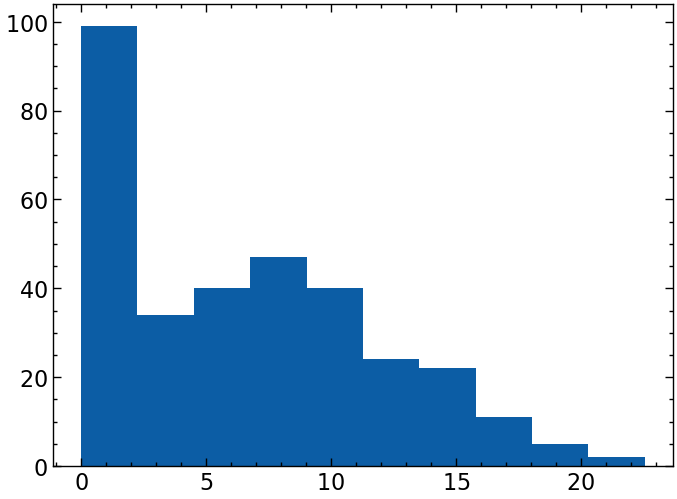

In [69]:
plt.hist((results_fagn1['best.reduced_chi_square'] - results_float['best.reduced_chi_square']))

<ipython-input-137-ffe118e5aee7>:10: RuntimeWarning: invalid value encountered in divide
  dM = 0.434*results_float['bayes.stellar.m_star_err']/results_float['bayes.stellar.m_star']


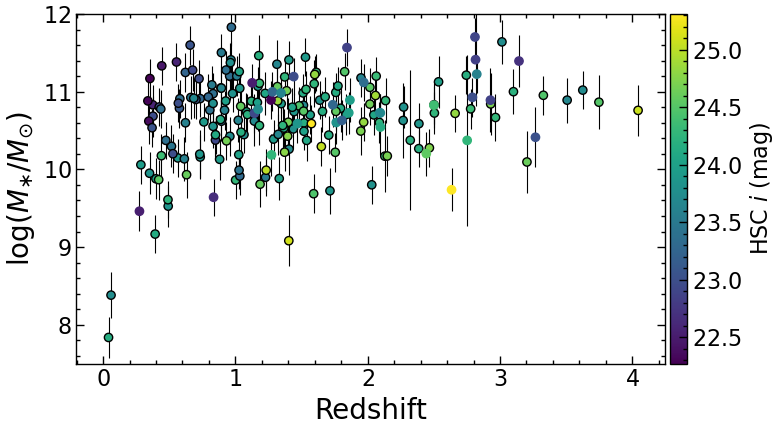

In [137]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

hdul = fits.open('./cigale/hsc/fagn1/out/results.fits')
results_fagn1 = hdul[1].data

hdul = fits.open('./cigale/hsc/float/out/results.fits')
results_float = hdul[1].data

mask_chi2 = ((results_fagn1['best.reduced_chi_square'] - results_float['best.reduced_chi_square']) > 2) & (results_float['best.reduced_chi_square'] < 10)
dM = 0.434*results_float['bayes.stellar.m_star_err']/results_float['bayes.stellar.m_star']
dM = np.sqrt(dM**2 + (0.24)**2)


fig, ax = plt.subplots(1,1, figsize=(8, 4.5))

#ax.scatter(z[~mask_chi2], np.log10(results_float['bayes.stellar.m_star'][~mask_chi2]),
#             edgecolors='k', c='none', marker='o', alpha=0.5)

mask_spec = data_agn['r_z'][idx_agn2COSMOS20] < 3
ax.scatter(z[mask_chi2 & mask_spec], np.log10(results_float['bayes.stellar.m_star'][mask_chi2 & mask_spec]),
                c=data_agn['i-mag'][idx_agn2COSMOS20][mask_chi2 & mask_spec],
                marker='o', edgecolors='k', label='spec-z')

im = ax.scatter(z[mask_chi2 & ~mask_spec], np.log10(results_float['bayes.stellar.m_star'][mask_chi2 & ~mask_spec]),
                c=data_agn['i-mag'][idx_agn2COSMOS20][mask_chi2 & ~mask_spec],
                marker='o', label='photo-z')

ax.errorbar(z[mask_chi2], np.log10(results_float['bayes.stellar.m_star'][mask_chi2]),
            yerr=dM[mask_chi2], marker=None, linestyle='none', color='k', zorder=-1, lw=0.8)


#ax.legend(loc=4, frameon=True)
ax.set_xlabel('Redshift', fontsize=20)
ax.set_ylabel(r'$\log(M_{\ast} / M_{\odot})$', fontsize=20)

#ax.set_xlim(7.5, 12)
ax.set_ylim(7.5, 12)

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='3%', pad=0.05)
fig.colorbar(im, cax=cax)
cax.set_ylabel(r'HSC $i$ (mag)')


fig.tight_layout()
fig.savefig('massredshift.pdf', dpi=300)